In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 10

#HYPERPARAMETERS
preproc = 1
l1 = 6
l2 = 8
l3 = 6

fit_level = 2

lr = 0.1
max_counter = 50
max_Nepochs = 3500

In [3]:
def read_LHEF_data():
    """Read histograms of data

    Args:
        num_obs (int): number of files to read data from

    Returns:
        tuple: returns tuple of lists and arrays containing the data
    """

    filenames = ["data_Enu_mu"]
    (binwidths, events, xvals_per_obs, max_events, min_events, xlabels) = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    val_n = np.loadtxt(f"data/{filenames[0]}_n.dat", unpack=True)
    val_p = np.loadtxt(f"data/{filenames[0]}_p.dat", unpack=True)
    
    val = 74 / 183 * val_p + (183 - 74) / 183 * val_n
    diff = 100
    val *= diff 
    err = val/20
    events = val
    xvals_per_obs = np.arange(0, 6000, 100)
    min_events = val - err
    max_events = (val + err)
    binwidths = diff 

    xlabels.append(filenames[0].replace(".dat", ""))

    events_per_obs = events

    return (
        events,
        max_events,
        min_events,
        xvals_per_obs,
        binwidths,
        xlabels,
        events_per_obs,
    )

In [4]:
# from read_fk_table import get_fk_table

import pandas as pd
# import torch
import torch.nn.functional


def get_fk_table(filename):
    """This function reads the fk table for the neutrino flux and pads them for computational efficiency later on

    Returns:
        tuple: x_alphas(grid points) and the fk table in tensor to fit torch
    """

    file_path_n = f"data/{filename}_n.dat"
    df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
    fk_table_n = df_n.to_numpy()

    file_path_p = f"data/{filename}_p.dat"
    df_p = pd.read_csv(file_path_p, sep="\s+", header=None)
    fk_table_p = df_p.to_numpy()

    x_alpha = fk_table_p[0, :]
    x_alpha = x_alpha.reshape(len(x_alpha), 1)

    fk_table = (74 / 183 )* fk_table_p + ((183 - 74) / 183) * fk_table_n

    # strip first row to get fk table
    fk_table = fk_table[1:, :]

    x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
    fk_table = torch.tensor(fk_table, dtype=torch.float32)

    return x_alpha, fk_table

filename = "FK_Enu_mu"
x_alphas, fk_tables_mu = get_fk_table(filename = filename)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_36214/2334289227.py:16: SyntaxWarning: invalid escape sequence '\s'
  df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_36214/2334289227.py:20: SyntaxWarning: invalid escape sequence '\s'
  df_p = pd.read_csv(file_path_p, sep="\s+", header=None)


In [5]:
events, max_events, min_events, xvals_per_obs, binwidths, xlabels, events_per_obs, = read_LHEF_data()

def rebin_fk(faser_bins,fk_tables,data,data_max,data_min):

    xvals_per_obs = np.arange(0, 6000, 100)
    print(xvals_per_obs)
    # data = np.array(data)
    data_faser,data_faser_min,data_faser_max, = [],[],[]
    fk_tables_faser = []
    lower_bound = 100
    # faser_bins = [300, 600, 1000,1900]
    for bin_val in faser_bins:
        indices = np.where((xvals_per_obs < bin_val) & (xvals_per_obs >= lower_bound))[0]

        print(indices)

        data_faser.append(np.sum(data[min(indices):max(indices)+1]))
        data_faser_min.append(np.sum(data_min[min(indices):max(indices)+1]))
        data_faser_max.append(np.sum(data_max[min(indices):max(indices)+1]))

        # xvals_per_obs = xvals_per_obs[max(indices)  :]
  
        summed_column = torch.sum(fk_tables[min(indices):max(indices) +1, :], axis=0)
        summed_column = summed_column.unsqueeze(0)

        fk_tables_faser.append(summed_column)

        # min_range = max_range
        lower_bound = bin_val

    # xvals_per_obs_faser.append(xvals_per_obs[-1])    
    # summed_column = torch.sum(fk_tables[max_range:, :], axis=0)
    # summed_column = summed_column.unsqueeze(0)
    # data_faser.append(np.sum(data[max_range:]))
    # data_faser_min.append(np.sum(data_min[max_range:]))
    # data_faser_max.append(np.sum(data_max[max_range:]))
    # fk_tables_faser.append(summed_column)


    fk_tables_faser = torch.cat(fk_tables_faser, dim=0)

    
    data_faser = np.array(data_faser)
    data_faser_min = np.array(data_faser_min)
    data_faser_max = np.array(data_faser_max)


    return data_faser, data_faser_min, data_faser_max, xvals_per_obs, binwidths, xlabels, events_per_obs,fk_tables_faser

# faser_bins_mu = [1220,2713.75, 4207.5,6000]
faser_bins_mu = [300, 600,1000,1900]
data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs,fk_table_mu = rebin_fk(faser_bins_mu,fk_tables_mu,events,max_events,min_events)

xvals_per_obs_mu = [300, 600,1000,1900]
xvals_per_obs = [300, 600,1000,1900]


[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700
 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100
 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500
 5600 5700 5800 5900]
[1 2]
[3 4 5]
[6 7 8 9]
[10 11 12 13 14 15 16 17 18]


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_36214/3405678409.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_36214/3405678409.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


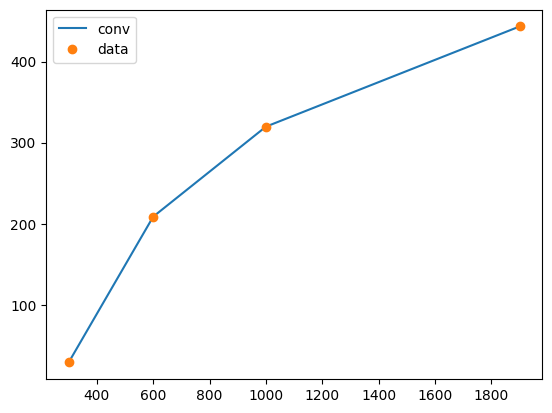

In [6]:
pdf = "faserv"
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_table_mu,faser_pdf) * binwidths 
plt.plot(xvals_per_obs_mu,conv,label='conv')

faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
plt.plot(xvals_per_obs,data,'o',label='data')
plt.legend()



In [7]:
#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)  
sig_stat = np.sqrt(data)
# xvals_per_obs = [100,300,600,-100,-300,1000] 
# xvals_per_obs = [100,300,600,100,-300,-100]  
# cov_matrix = np.array([
#     [9.2,-0.32,  0.08, -0.03,  0.00,  0.00],
#     [-0.32, 10.2, -0.43,  0.10, -0.01, -0.00],
#     [ 0.08, -0.43, 9.6, -0.31,  0.04, -0.02],
#     [-0.03,  0.10, -0.31, 22.3,-0.14,  0.01],
#     [ 0.00, -0.01,  0.04, -0.14, 12.1,-0.24],
#     [ 0.00, -0.00, -0.02,  0.01, -0.24,7.5]
# ])
# sig_sys = np.array(sig_sys)
# np.fill_diagonal(cov_matrix, sig_stat**2 + sig_sys**2)
# cov_matrix = np.linalg.inv(cov_matrix)
# cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

delta plus = [ 1.44973149 10.43632681 15.98481523 22.15947311]
sig sys = [ 1.44973149 10.43632681 15.98481523 22.15947311]
[ 1.44973149 10.43632681 15.98481523 22.15947311]
[ 5.38466618 14.44737126 17.88005326 21.05206551]
1
[ -0.87419176   4.58496319 -12.29388829  27.47486566] [ -1.49655481 -10.38731571 -19.89363133 -17.91900578]
2
[-1.45266649 -6.54370918 -7.75497735 -3.7846551 ] [ -1.3665531   -8.29311402 -31.74225222  30.04756719]
1
[-0.3960102  -1.6565733   8.33083917 -9.42266796] [ -4.61528771 -19.8086694    9.48604455  -8.95414325]
2
[ -1.57431221   9.97174666 -13.67057246  -9.92521444] [  0.90037638 -19.52520386  13.24541248  10.36969173]
1
[  1.22212539  -6.88154699  -2.30975408 -45.8936771 ] [  4.56031273   6.55203103 -41.90894231 -13.19533403]
2
[-2.20877642 -7.31629015  7.39980285 14.90345404] [ 2.57343828  2.34853959 -7.48374309  7.24355595]
1
[  1.15714259  -4.97251322 -17.31129829   9.73461927] [  0.57992836 -10.70387888  19.34429835   4.02398245]
2
[ 2.12799917  3.36161

In [8]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[ 28.99462986 208.72653618 319.69630453 443.18946212]
[tensor([ 26.6239, 202.9242, 287.5088, 452.7453]), tensor([ 23.9833, 187.2613, 337.5132, 424.8127]), tensor([ 34.7771, 208.3970, 275.4776, 384.1005]), tensor([ 30.7317, 193.0501, 321.7293, 456.9481]), tensor([ 25.1439, 199.3745, 287.3458, 482.5199]), tensor([ 27.9407, 196.3528, 307.8587, 441.0406]), tensor([ 24.6831, 206.2201, 366.3940, 473.5916]), tensor([ 25.7838, 209.5803, 302.0106, 367.9166]), tensor([ 23.8073, 191.5264, 315.5469, 465.8705]), tensor([ 25.2973, 190.7773, 338.4478, 436.1866])]
[tensor([ 23.8047, 188.0874, 248.0116, 479.0082]), tensor([ 23.3094, 177.7078, 337.0880, 425.2571]), tensor([ 35.1417, 203.4293, 275.3937, 406.2475]), tensor([ 32.5498, 213.5961, 334.6560, 444.6232]), tensor([ 18.1914, 204.0441, 297.3598, 509.6154]), tensor([ 21.0628, 224.5881, 324.8840, 487.1629]), tensor([ 20.1599, 212.0229, 382.1255, 443.9580]), tensor([ 19.7823, 212.6721, 275.8737, 418.6236]), tensor([ 24.8990, 206.9982, 308.6377, 470.30

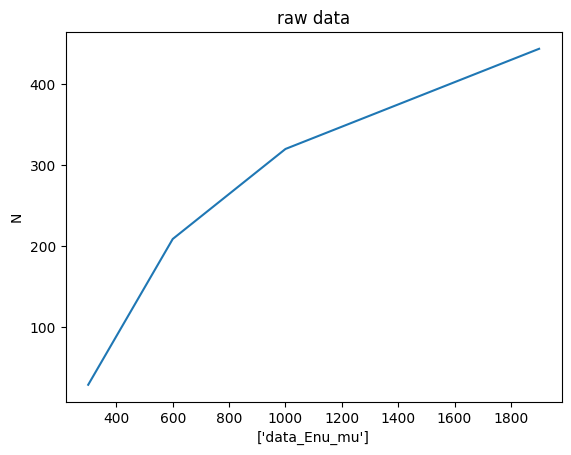

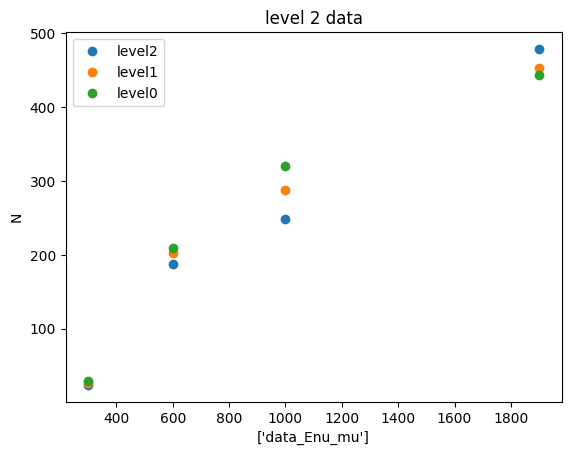

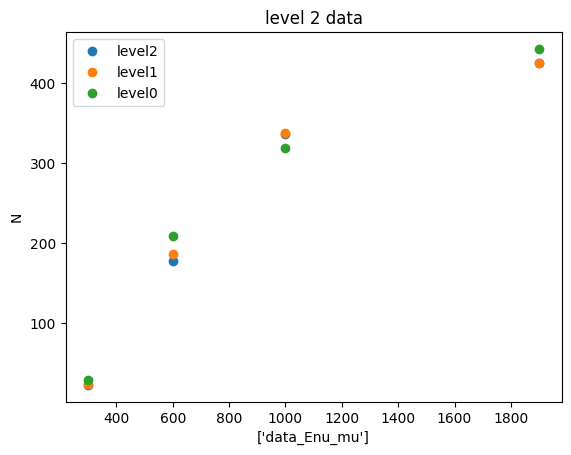

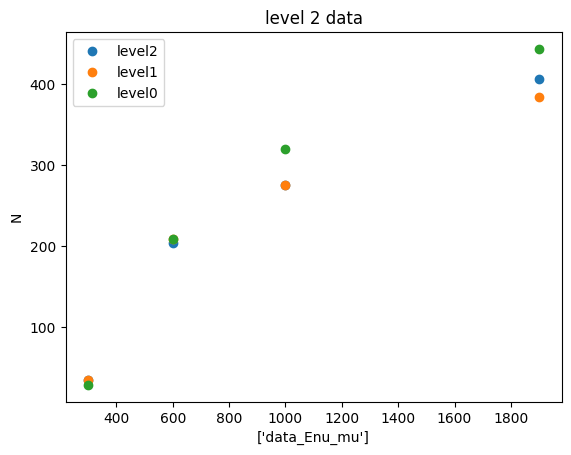

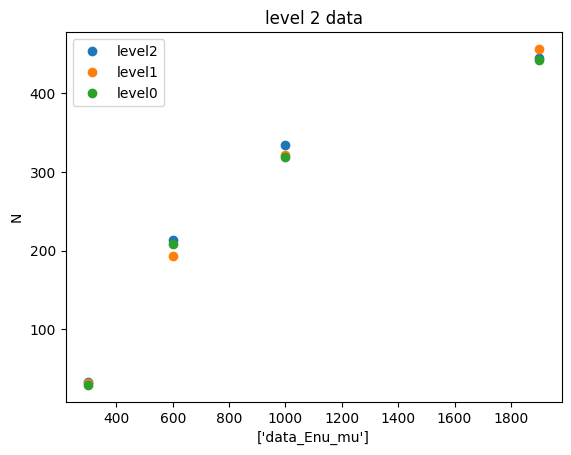

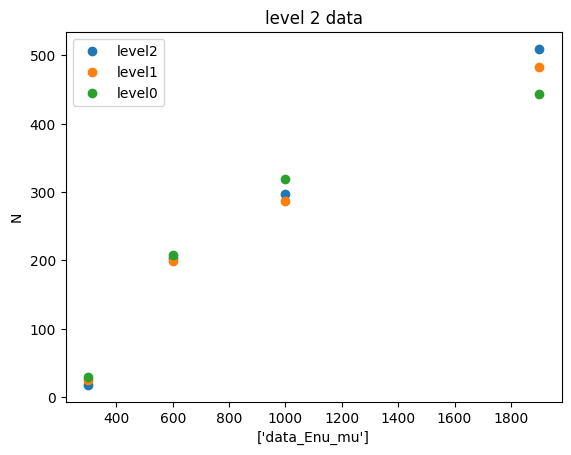

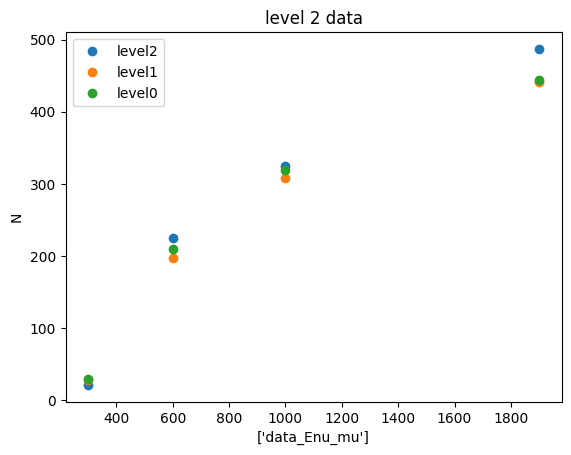

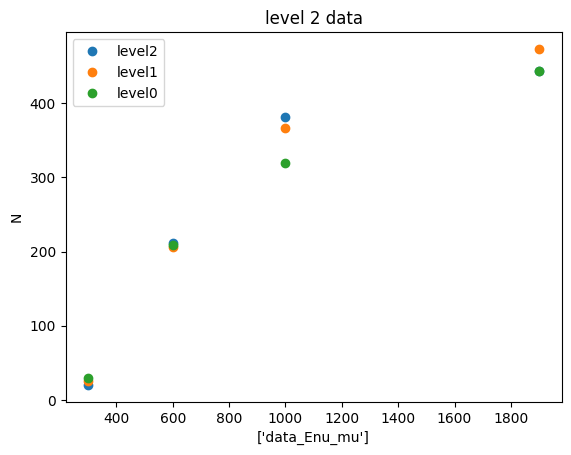

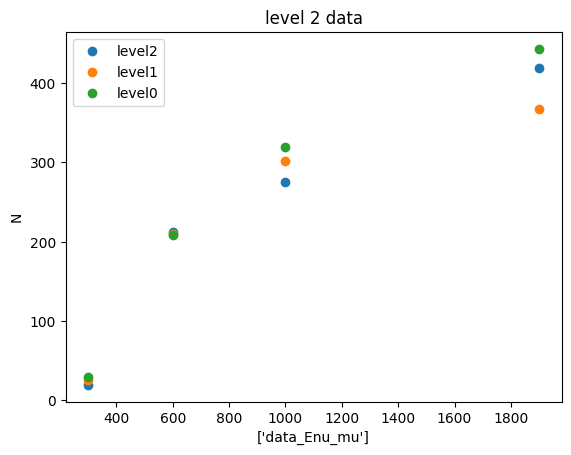

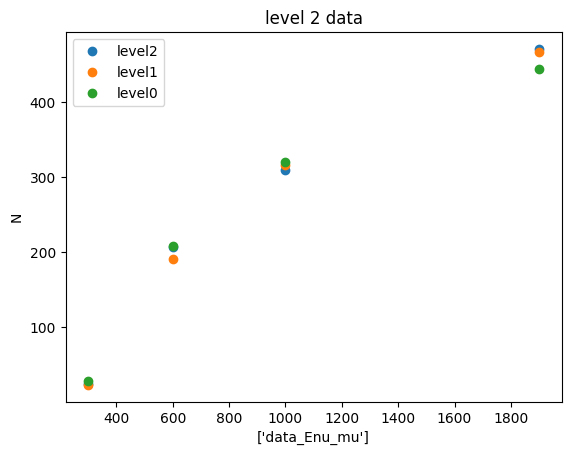

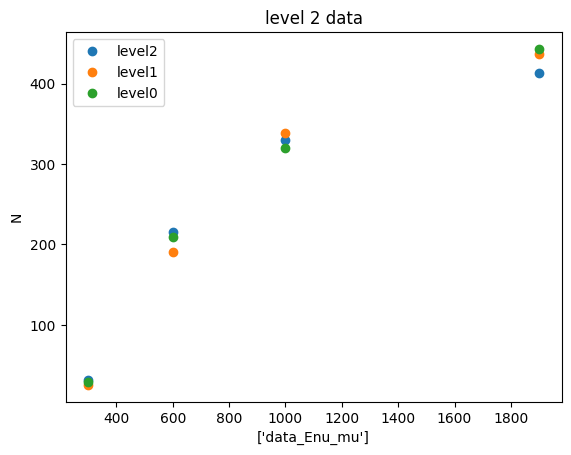

In [9]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], 'o',label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], 'o',label="level1"
    )
    plt.plot(xvals_per_obs, data,'o',label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [10]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [11]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

            # self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            # self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            # self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            alpha = 1 - torch.nn.functional.softplus(self.alpha)
            return self.gamma * (1 - x) ** self.beta * x**(1-alpha) 
            # return 10 * (1 - x)**2 * x**(1.5) 
            # return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_nu
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix)
        return loss

In [13]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
neutrino_pdfs_mu,neutrino_pdfs_mub,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[],[]

In [14]:
if preproc == 1:
    alpha,beta,gamma = 1,1,10
    model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
         
            # model.load_state_dict(model_params)    

    criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
def perform_fit(pred,REPLICAS):
    for i in range(REPLICAS):
        losses = []
        
        pred[i] = pred[i].squeeze()
        model.train()
        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 6000
        for ep in range(num_epochs):
        # while counter < max_counter:  
        #     if num_epochs>max_Nepochs:
        #         break
            
            # num_epochs+=1
            optimizer.zero_grad()
            # y_pred =  model(x_alphas) 
            y_pred =  model(x_alphas) * x_alphas
            y_preds = torch.matmul(fk_table_mu,y_pred)  * binwidths 

            y_preds = y_preds.squeeze()

            loss = criterion(y_preds, pred[i],cov_matrix)
            loss.backward()
            # print(loss)
    
            losses.append(loss.item())
            optimizer.step()
            
            if ep % 100 == 0:
                print(loss.detach().numpy())   
            if loss <.2:
                break
            # if loss < best_loss:
            #     best_loss = loss
            #     counter = 0
            # else:
            #     counter +=1   

        if loss < 10:    

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # save outcome of fit and its measures for postfit selection criteria
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()
            f_nu_mu = model(x_vals).detach().numpy().flatten() 
            
            # print(preproc_pdf.shape)

            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals).detach().numpy().flatten())

            N_event_pred.append(y_preds.detach().numpy())
            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
            neutrino_pdfs_mu.append(f_nu_mu)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model
    return chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model

120.530304
47.07547
43.5757
36.779465
12.39054
3.373098
0.6785164
0.67027867
0.6630363
0.65514135
0.64659494
0.63739616
0.62754095
0.61702436
0.60584176
0.5939488
0.58139783
0.568205
0.5542956
0.53971547
0.5244907
0.5214119
0.4919697
0.47476256
0.45691773
0.43844458
0.41942513
0.30508652
reduced chi^2 level 2 = 0.1991211473941803
Constrained alpha: -6.192023754119873
Constrained beta: 21.672168731689453
Constrained gamma: 27.25652503967285
counter = 0


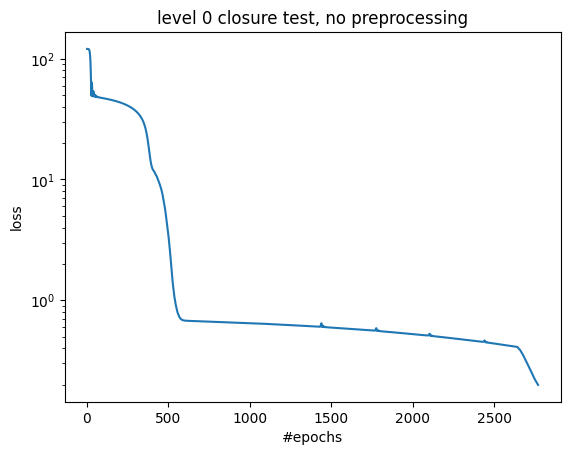

4.587934
0.6595962
0.64898473
0.6382947
0.62753105
0.61672574
0.605913
0.5951247
0.5843929
0.57374734
0.5632146
0.5528194
0.54258287
0.532522
0.52265024
0.51297855
0.5035142
0.49426207
0.4852238
0.4764009
0.46779147
0.45939493
0.4512081
0.43122718
0.405036
0.2836721
reduced chi^2 level 2 = 0.1995062679052353
Constrained alpha: -7.006338119506836
Constrained beta: 41.339046478271484
Constrained gamma: 32.69908905029297
counter = 0


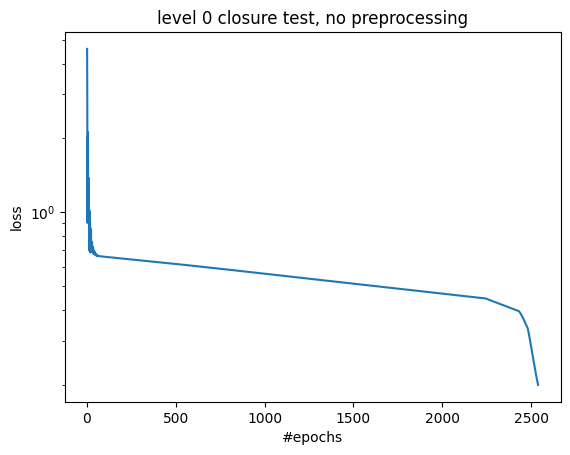

4.4219923
reduced chi^2 level 2 = 0.19701597094535828
Constrained alpha: -7.141845703125
Constrained beta: 37.83571243286133
Constrained gamma: 35.1054801940918
counter = 0


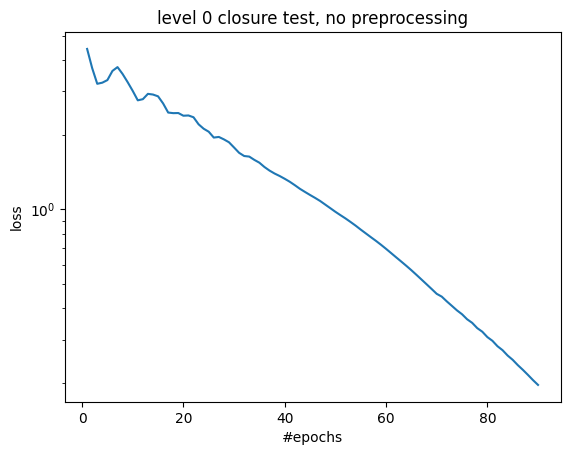

1.8809422
reduced chi^2 level 2 = 0.132573664188385
Constrained alpha: -7.180350303649902
Constrained beta: 38.512237548828125
Constrained gamma: 35.80571746826172
counter = 0


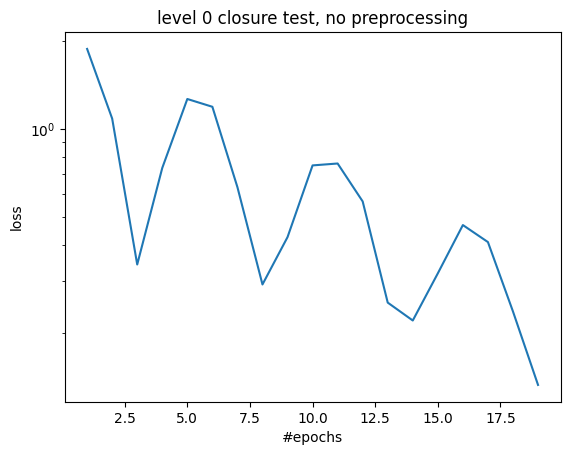

2.8045354
reduced chi^2 level 2 = 0.19987542927265167
Constrained alpha: -6.908872604370117
Constrained beta: 33.7906379699707
Constrained gamma: 32.50178146362305
counter = 0


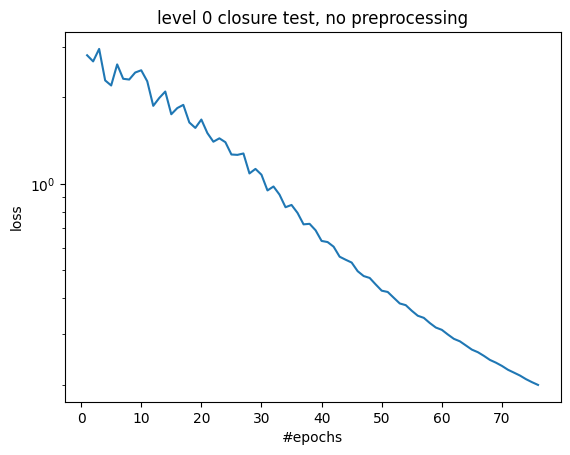

0.85865355
reduced chi^2 level 2 = 0.18921831250190735
Constrained alpha: -6.886076927185059
Constrained beta: 33.8338737487793
Constrained gamma: 32.23182678222656
counter = 0


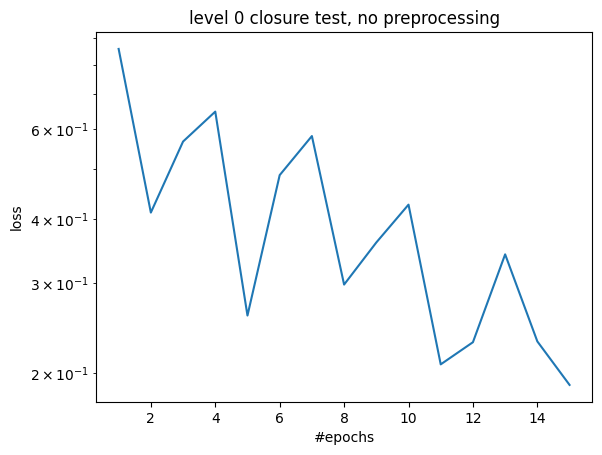

3.116394
reduced chi^2 level 2 = 0.16747723519802094
Constrained alpha: -6.7781524658203125
Constrained beta: 34.737220764160156
Constrained gamma: 30.868852615356445
counter = 0


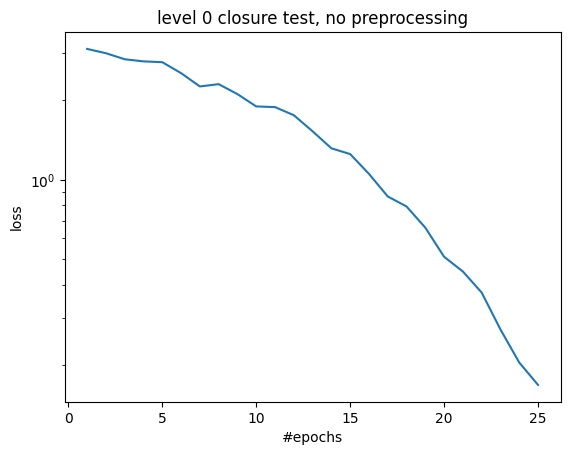

4.181485
reduced chi^2 level 2 = 0.1788453459739685
Constrained alpha: -6.874793529510498
Constrained beta: 35.36367416381836
Constrained gamma: 31.31014633178711
counter = 0


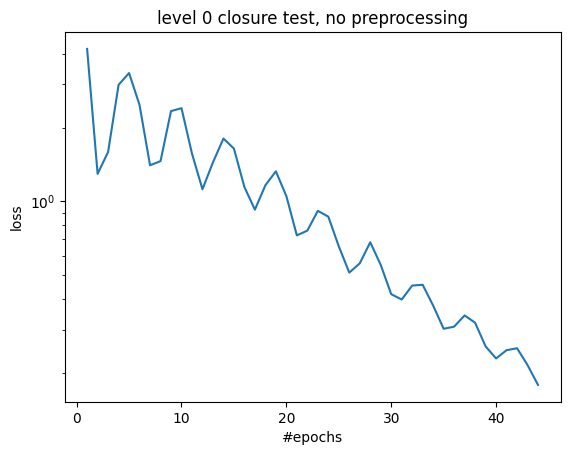

1.0687816
reduced chi^2 level 2 = 0.13610133528709412
Constrained alpha: -6.899682521820068
Constrained beta: 34.853843688964844
Constrained gamma: 31.669361114501953
counter = 0


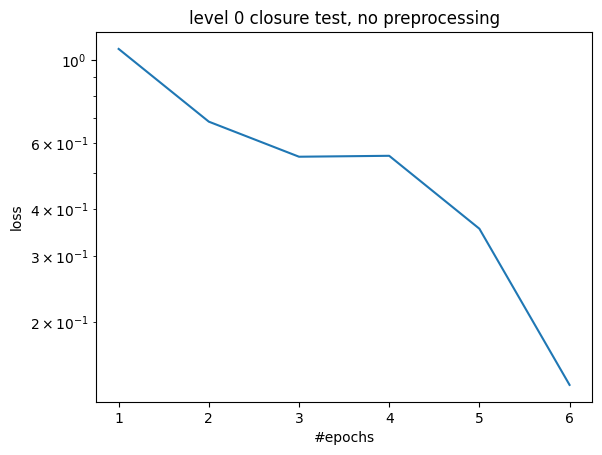

2.3805103
0.7224761
0.5853002
reduced chi^2 level 2 = 0.1976848542690277
Constrained alpha: -7.312036514282227
Constrained beta: 40.671897888183594
Constrained gamma: 33.95160675048828
counter = 0


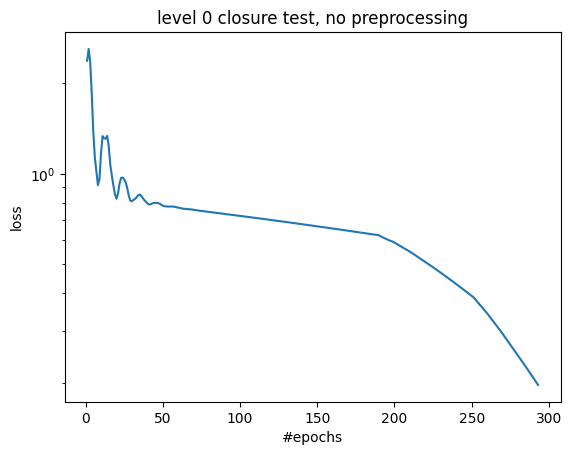

In [15]:
chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model = perform_fit(pred,REPLICAS)

In [16]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

In [17]:
x_vals = x_vals.detach().numpy().flatten()
faser_pdf_mu,x_faser = read_pdf(pdf,x_vals,14) 
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu_mu = np.mean(neutrino_pdfs_mu,axis=0) 
mean_fnu_mub = np.mean(neutrino_pdfs_mub,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

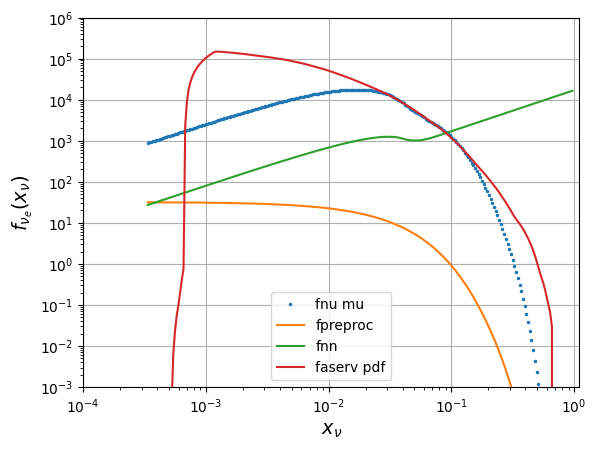

In [19]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu_mu*x_vals,'o',label="fnu mu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf*x_vals,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mu,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:71: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:72: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu - error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:73: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu + error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:170: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


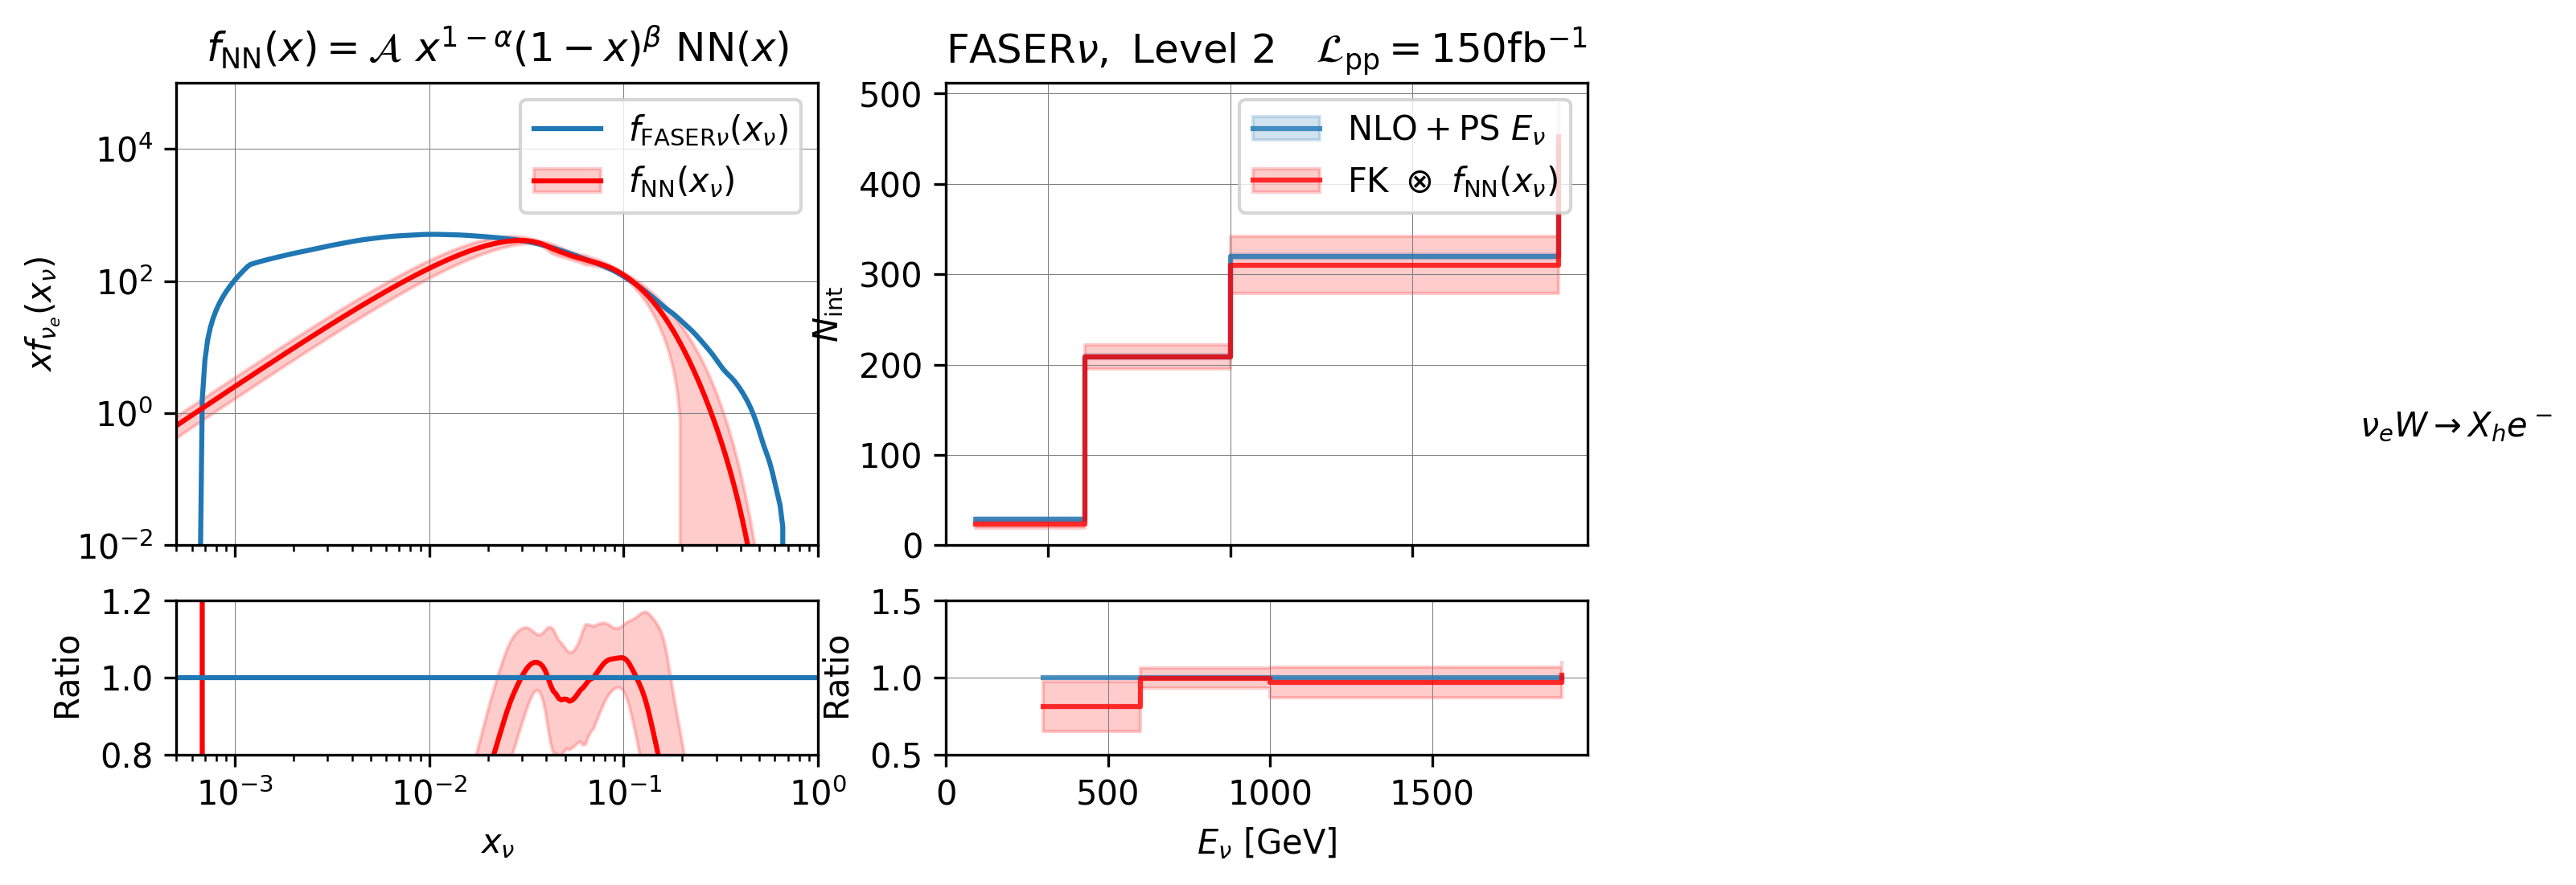

In [20]:
from plot_results import plot
import numpy as np
sig_tot = np.sqrt(sig_sys+sig_stat)
x_vals = np.array(x_vals)
plot(x_vals, neutrino_pdfs_mu, level0, N_event_pred, sig_tot, xvals_per_obs,14)


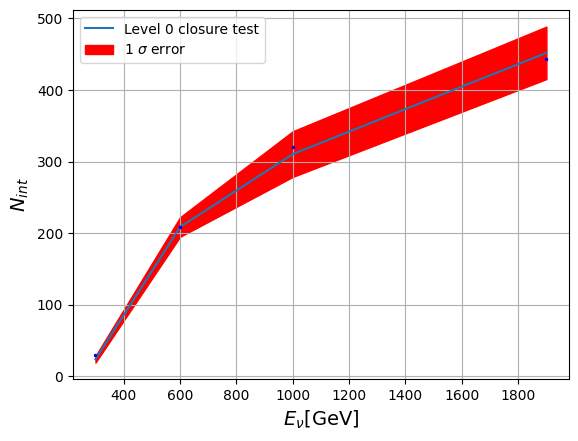

In [21]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [22]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo